# Reading Frame Analysis: Comparing Overlapping Gene Stability Across Frames

This notebook analyzes how reading frame affects the stability of overlapping genes.

**Reading Frames:**
- Frame 0: `overlap % 3 == 0` (in-frame, codons align)
- Frame +1: `overlap % 3 == 1` (shifted by 1 nucleotide)
- Frame +2: `overlap % 3 == 2` (shifted by 2 nucleotides)

**Metrics:**
1. **Final Energy Distance (`Dist`)**: Mean absolute distance from natural mean energy
2. **Minimum Energy Distance (`Min_Dist`)**: Closest approach to natural mean during simulation
3. **Iterations to Convergence (`Iter_Converged`)**: When energy first enters 1 std dev of natural mean

**Analysis:**
- Compare metrics across reading frames
- Statistical tests for frame differences
- Visualizations of frame-specific patterns

In [2]:
# --- IMPORTS ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pandas as pd
import time
import json
from scipy import stats
from tqdm import tqdm

# Add current directory to path to import overlappingGenes
sys.path.append(os.getcwd())
import overlappingGenes as og

plt.style.use('seaborn-v0_8-whitegrid')
print("Imports complete.")

Imports complete.


## Parameters

Configure overlap ranges to include ALL THREE reading frames.



  | Frame | Condition | Meaning |
  |:---:|:---:|:---|
  | **Frame 0** | `overlap % 3 == 0` | **In-frame** — Codons align perfectly. Both genes read the overlap starting at a codon boundary. |
  | **Frame +1** | `overlap % 3 == 1` | **Shifted by 1** — Gene 2 reads the DNA starting 1 nucleotide into Gene 1's codon. |    
  | **Frame +2** | `overlap % 3 == 2` | **Shifted by 2** — Gene 2 reads the DNA starting 2 nucleotides into Gene 1's codon. |   


In [ ]:
'''
  Gene 1 codons:  |AAA|BBB|CCC|DDD|
                           ↓ overlap starts here
  Gene 2 Frame 0: |AAA|BBB|CCC|DDD|  ← codons align (overlap = 12, 18, 24...)
  Gene 2 Frame 1:   |AAB|BBC|CCD|    ← shifted 1nt (overlap = 13, 19, 25...)
  Gene 2 Frame 2:    |ABB|BCC|CDD|   ← shifted 2nt (overlap = 14, 20, 26...)
'''

In [3]:
# =============================================================================
# PARAMETERS - All three reading frames
# =============================================================================

def generate_overlaps(start=12, stop=90, reading_frames=[0, 1, 2]):
    """
    Generate overlap values for specified reading frames.
    
    Parameters:
    -----------
    start : int
        Minimum overlap (nucleotides). Must be >= 6.
    stop : int
        Maximum overlap (nucleotides, exclusive).
    reading_frames : list of int
        Which reading frames to include. Options: 0, 1, 2
        
    Returns:
    --------
    list : Sorted list of overlap values
    """
    overlaps = []
    for ov in range(start, stop):
        if ov % 3 in reading_frames:
            overlaps.append(ov)
    return sorted(overlaps)


# === ALL THREE READING FRAMES ===
# Sample overlaps from each frame: 12-90nt range, step of 6 within each frame
# This gives us comparable sample sizes across frames
OVERLAPS_FRAME_0 = list(range(12, 90, 6))   # [12, 18, 24, 30, ...]
OVERLAPS_FRAME_1 = list(range(13, 90, 6))   # [13, 19, 25, 31, ...]
OVERLAPS_FRAME_2 = list(range(14, 90, 6))   # [14, 20, 26, 32, ...]

OVERLAPS = sorted(OVERLAPS_FRAME_0 + OVERLAPS_FRAME_1 + OVERLAPS_FRAME_2)

# --- SIMULATION PARAMETERS ---
ITERATIONS = 250_000      # MC iterations per trial
N_TRIALS = 40             # Number of trials per overlap value
WHENTOSAVE = 0.01         # Save history every 1% of iterations

# --- PRINT CONFIGURATION ---
print("=" * 60)
print("READING FRAME ANALYSIS CONFIGURATION")
print("=" * 60)
print(f"Total overlaps to scan: {len(OVERLAPS)} values")
print(f"  Frame 0 (in-frame):  {len(OVERLAPS_FRAME_0)} values - {OVERLAPS_FRAME_0[:5]}...")
print(f"  Frame +1:            {len(OVERLAPS_FRAME_1)} values - {OVERLAPS_FRAME_1[:5]}...")
print(f"  Frame +2:            {len(OVERLAPS_FRAME_2)} values - {OVERLAPS_FRAME_2[:5]}...")
print(f"\nSimulation: {ITERATIONS:,} iterations x {N_TRIALS} trials per overlap")
print("=" * 60)

READING FRAME ANALYSIS CONFIGURATION
Total overlaps to scan: 39 values
  Frame 0 (in-frame):  13 values - [12, 18, 24, 30, 36]...
  Frame +1:            13 values - [13, 19, 25, 31, 37]...
  Frame +2:            13 values - [14, 20, 26, 32, 38]...

Simulation: 250,000 iterations x 40 trials per overlap


In [4]:
# --- DATA LOADING ---

BASE_DIR = "bmDCA"
try:
    ALL_PF_DIRS = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d)) and d.startswith("PF")])
    print(f"Found {len(ALL_PF_DIRS)} Protein Families: {ALL_PF_DIRS}")
except FileNotFoundError:
    print(f"Error: Base directory '{BASE_DIR}' not found.")
    ALL_PF_DIRS = []

# Cache for parameters to avoid reloading
PARAMS_CACHE = {}
NATURAL_STATS_CACHE = {}

def get_params_and_stats(pf_name):
    if pf_name in PARAMS_CACHE:
        return PARAMS_CACHE[pf_name], NATURAL_STATS_CACHE[pf_name]
    
    # Load DCA Params
    param_file = os.path.join(BASE_DIR, pf_name, f"{pf_name}_params.dat")
    J, h = og.extract_params(param_file)
    PARAMS_CACHE[pf_name] = [J, h]
    
    # Load Natural Stats
    nat_file = os.path.join(BASE_DIR, pf_name, f"{pf_name}_naturalenergies.txt")
    energies = og.load_natural_energies(nat_file)
    NATURAL_STATS_CACHE[pf_name] = (np.mean(energies), np.std(energies))
    
    return [J, h], (np.mean(energies), np.std(energies))

Found 12 Protein Families: ['PF00004', 'PF00041', 'PF00072', 'PF00076', 'PF00096', 'PF00153', 'PF00271', 'PF00397', 'PF00512', 'PF00595', 'PF02518', 'PF07679']


In [5]:
# --- LOAD OPTIMAL TEMPERATURES ---

OPTIMAL_TEMPS_FILE = "optimal_temperatures.json"
OPTIMAL_TEMPS = {}

if os.path.exists(OPTIMAL_TEMPS_FILE):
    print(f"Loading optimal temperatures from {OPTIMAL_TEMPS_FILE}...")
    with open(OPTIMAL_TEMPS_FILE, 'r') as f:
        OPTIMAL_TEMPS = json.load(f)
    print(f"Loaded temperatures for {len(OPTIMAL_TEMPS)} protein families.")
else:
    print("Warning: optimal_temperatures.json not found. Using default T=1.0 for all.")

Loading optimal temperatures from optimal_temperatures.json...
Loaded temperatures for 12 protein families.


In [6]:
# --- PAIRWISE SCAN FUNCTION ---

def run_pairwise_scan(pf_list, optimal_temps, overlaps=None):
    """
    Run pairwise overlap scan for all protein family combinations.
    
    Parameters:
    -----------
    pf_list : list
        List of protein family names
    optimal_temps : dict
        Dictionary of optimal temperatures per protein family
    overlaps : list, optional
        List of overlap values to scan. If None, uses global OVERLAPS.
    """
    if overlaps is None:
        overlaps = OVERLAPS
    
    summary_data = []
    
    # Generate Pairs (Exclude self-pairs)
    pairs = []
    for i in range(len(pf_list)):
        for j in range(i + 1, len(pf_list)):
            pairs.append((pf_list[i], pf_list[j]))
            
    total_pairs = len(pairs)
    print(f"Starting Scan of {total_pairs} unique pairs...")
    print(f"Overlaps: {len(overlaps)} values from {min(overlaps)} to {max(overlaps)} nt")
    print(f"Reading frames: {sorted(set(ov % 3 for ov in overlaps))}")
    print(f"Trials per overlap: {N_TRIALS}")
    print(f"Total simulations: {total_pairs * len(overlaps) * N_TRIALS:,}")
    
    start_time_all = time.time()
    
    # Progress bar for pairs
    pair_pbar = tqdm(pairs, desc="Gene Pairs", position=0)
    
    for pf1, pf2 in pair_pbar:
        pair_pbar.set_description(f"{pf1} vs {pf2}")
        
        # Load Params
        params1, (nat_mean1, nat_std1) = get_params_and_stats(pf1)
        params2, (nat_mean2, nat_std2) = get_params_and_stats(pf2)
        
        t1 = optimal_temps.get(pf1, 1.0)
        t2 = optimal_temps.get(pf2, 1.0)
        
        len1 = len(params1[1]) // 21
        len2 = len(params2[1]) // 21
        
        # Filter overlaps that are valid for this pair
        max_overlap = min(len1, len2) * 3 - 6
        valid_overlaps = [ov for ov in overlaps if ov <= max_overlap]
        
        # Progress bar for overlaps
        for ov in tqdm(valid_overlaps, desc="Overlaps", position=1, leave=False):
            trial_e1_final = []
            trial_e2_final = []
            
            trial_e1_min_dist = []
            trial_e2_min_dist = []
            
            trial_iter_conv_1 = []
            trial_iter_conv_2 = []
            
            for _ in range(N_TRIALS):
                init_seq = og.initial_seq_no_stops(len1, len2, ov, quiet=True)
                
                # Capture history
                # Returns: final_seq, accepted, hist1, hist2, final_energies, best_energies, best_seq
                result = og.overlapped_sequence_generator_int(
                    params1, params2, init_seq,
                    numberofiterations=ITERATIONS,
                    whentosave=WHENTOSAVE, 
                    quiet=True,
                    T1=t1, T2=t2
                )
                hist1 = result[2]
                hist2 = result[3]
                final_energies = result[4]
                e1, e2 = final_energies[0], final_energies[1]
                
                trial_e1_final.append(e1)
                trial_e2_final.append(e2)
                
                # --- CALCULATE METRICS ---
                # Distance Trajectories (abs applied first)
                dists1 = np.abs(hist1 - nat_mean1)
                dists2 = np.abs(hist2 - nat_mean2)
                
                # 1. Minimum Distance Achieved
                min_d1 = np.min(dists1) if len(dists1) > 0 else abs(e1 - nat_mean1)
                min_d2 = np.min(dists2) if len(dists2) > 0 else abs(e2 - nat_mean2)
                
                trial_e1_min_dist.append(min_d1)
                trial_e2_min_dist.append(min_d2)
                
                # 2. Iterations to Convergence (Within 1 Standard Deviation)
                step_size = ITERATIONS * WHENTOSAVE
                
                conv_idxs_1 = np.where(dists1 <= nat_std1)[0]
                if len(conv_idxs_1) > 0:
                    iter_conv_1 = (conv_idxs_1[0] + 1) * step_size
                else:
                    iter_conv_1 = ITERATIONS
                
                conv_idxs_2 = np.where(dists2 <= nat_std2)[0]
                if len(conv_idxs_2) > 0:
                    iter_conv_2 = (conv_idxs_2[0] + 1) * step_size
                else:
                    iter_conv_2 = ITERATIONS
                
                trial_iter_conv_1.append(iter_conv_1)
                trial_iter_conv_2.append(iter_conv_2)
            
            # Save Summary
            # NOTE: Dist calculated as mean(abs(values)) to avoid cancellation
            summary_data.append({
                'PF1': pf1, 'PF2': pf2, 'Overlap': ov,
                'Reading_Frame': ov % 3,
                'Mean_E1': np.mean(trial_e1_final), 'Std_E1': np.std(trial_e1_final),
                'Mean_E2': np.mean(trial_e2_final), 'Std_E2': np.std(trial_e2_final),
                'Nat_Mean1': nat_mean1, 'Nat_Mean2': nat_mean2,
                'Nat_Std1': nat_std1, 'Nat_Std2': nat_std2,
                'Dist_1': np.mean(np.abs(np.array(trial_e1_final) - nat_mean1)),
                'Dist_2': np.mean(np.abs(np.array(trial_e2_final) - nat_mean2)),
                'Min_Dist_1': np.mean(trial_e1_min_dist),
                'Min_Dist_2': np.mean(trial_e2_min_dist),
                'Iter_Converged_1': np.mean(trial_iter_conv_1),
                'Iter_Converged_2': np.mean(trial_iter_conv_2)
            })
            
    total_dur = time.time() - start_time_all
    print(f"\nFull Scan Complete in {total_dur/60:.1f} minutes!")
    return pd.DataFrame(summary_data)

In [7]:
# --- RUN THE SCAN ---

RESULTS_FILE = "reading_frame_results.csv"

if 'ALL_PF_DIRS' in locals() and ALL_PF_DIRS:
    results_df = run_pairwise_scan(ALL_PF_DIRS, OPTIMAL_TEMPS)
    results_df.to_csv(RESULTS_FILE, index=False)
    print(f"Results saved to {RESULTS_FILE}")
else:
    print("No protein families found to scan. Check BASE_DIR.")

Starting Scan of 66 unique pairs...
Overlaps: 39 values from 12 to 86 nt
Reading frames: [0, 1, 2]
Trials per overlap: 40
Total simulations: 102,960


PF00004 vs PF00041:   0%|          | 0/66 [00:06<?, ?it/s]


KeyboardInterrupt: 

---
## Load Results (if already computed)

Run this cell to load previously computed results.

In [8]:
# --- LOAD EXISTING RESULTS ---

RESULTS_FILE = "reading_frame_results.csv"

if os.path.exists(RESULTS_FILE):
    results_df = pd.read_csv(RESULTS_FILE)
    print(f"Loaded {len(results_df)} rows from {RESULTS_FILE}")
    print(f"\nReading frames present: {sorted(results_df['Reading_Frame'].unique())}")
    print(f"Overlaps per frame:")
    for frame in sorted(results_df['Reading_Frame'].unique()):
        n_overlaps = results_df[results_df['Reading_Frame'] == frame]['Overlap'].nunique()
        print(f"  Frame {frame}: {n_overlaps} unique overlap values")
else:
    print(f"Results file '{RESULTS_FILE}' not found. Run the scan first.")

Loaded 2392 rows from reading_frame_results.csv

Reading frames present: [np.int64(0), np.int64(1), np.int64(2)]
Overlaps per frame:
  Frame 0: 13 unique overlap values
  Frame 1: 13 unique overlap values
  Frame 2: 13 unique overlap values


---
## Analysis: Reading Frame Comparison

Compare stability metrics across the three reading frames.

In [9]:
# --- COMPUTE COMBINED METRICS ---
# Average Dist_1 and Dist_2 for a single "stability" measure per row

if 'results_df' in locals():
    results_df['Avg_Dist'] = (results_df['Dist_1'] + results_df['Dist_2']) / 2
    results_df['Avg_Min_Dist'] = (results_df['Min_Dist_1'] + results_df['Min_Dist_2']) / 2
    results_df['Avg_Iter_Conv'] = (results_df['Iter_Converged_1'] + results_df['Iter_Converged_2']) / 2
    
    print("Added combined metrics: Avg_Dist, Avg_Min_Dist, Avg_Iter_Conv")
    results_df.head()

Added combined metrics: Avg_Dist, Avg_Min_Dist, Avg_Iter_Conv


In [10]:
# --- SUMMARY STATISTICS BY READING FRAME ---

if 'results_df' in locals():
    frame_summary = results_df.groupby('Reading_Frame').agg({
        'Avg_Dist': ['mean', 'std', 'median'],
        'Avg_Min_Dist': ['mean', 'std', 'median'],
        'Avg_Iter_Conv': ['mean', 'std', 'median']
    }).round(2)
    
    print("=" * 70)
    print("SUMMARY STATISTICS BY READING FRAME")
    print("=" * 70)
    print(frame_summary)
    print("\nLower Dist = Better (closer to natural energy)")
    print("Lower Iter_Conv = Better (faster convergence)")

SUMMARY STATISTICS BY READING FRAME
              Avg_Dist              Avg_Min_Dist              Avg_Iter_Conv  \
                  mean   std median         mean   std median          mean   
Reading_Frame                                                                 
0                15.92  6.37  14.69         1.51  2.52   0.48      24701.69   
1                18.15  7.44  16.56         2.34  3.29   0.87      31504.17   
2                14.38  5.14  13.44         1.08  1.73   0.43      22658.77   

                                   
                    std    median  
Reading_Frame                      
0              19791.97  18234.38  
1              26486.72  22156.25  
2              18531.80  17640.62  

Lower Dist = Better (closer to natural energy)
Lower Iter_Conv = Better (faster convergence)


In [11]:
# --- STATISTICAL TESTS: KRUSKAL-WALLIS (non-parametric ANOVA) ---
# Tests whether reading frames have significantly different distributions

if 'results_df' in locals():
    print("=" * 70)
    print("KRUSKAL-WALLIS TEST: Are reading frames significantly different?")
    print("=" * 70)
    
    for metric in ['Avg_Dist', 'Avg_Min_Dist', 'Avg_Iter_Conv']:
        groups = [results_df[results_df['Reading_Frame'] == f][metric].values 
                  for f in [0, 1, 2]]
        
        stat, p_value = stats.kruskal(*groups)
        
        sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        print(f"\n{metric}:")
        print(f"  H-statistic: {stat:.2f}")
        print(f"  p-value: {p_value:.2e} {sig}")
    
    print("\n*** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

KRUSKAL-WALLIS TEST: Are reading frames significantly different?

Avg_Dist:
  H-statistic: 121.31
  p-value: 4.55e-27 ***

Avg_Min_Dist:
  H-statistic: 112.07
  p-value: 4.61e-25 ***

Avg_Iter_Conv:
  H-statistic: 92.24
  p-value: 9.33e-21 ***

*** p<0.001, ** p<0.01, * p<0.05, ns = not significant


In [12]:
# --- PAIRWISE MANN-WHITNEY U TESTS ---
# If Kruskal-Wallis is significant, test which pairs differ

if 'results_df' in locals():
    print("=" * 70)
    print("PAIRWISE MANN-WHITNEY U TESTS (with Bonferroni correction)")
    print("=" * 70)
    
    frame_pairs = [(0, 1), (0, 2), (1, 2)]
    alpha = 0.05
    bonferroni_alpha = alpha / 3  # 3 comparisons
    
    for metric in ['Avg_Dist', 'Avg_Min_Dist', 'Avg_Iter_Conv']:
        print(f"\n{metric}:")
        for f1, f2 in frame_pairs:
            g1 = results_df[results_df['Reading_Frame'] == f1][metric].values
            g2 = results_df[results_df['Reading_Frame'] == f2][metric].values
            
            stat, p_value = stats.mannwhitneyu(g1, g2, alternative='two-sided')
            
            sig = "*" if p_value < bonferroni_alpha else "ns"
            direction = "<" if np.median(g1) < np.median(g2) else ">" if np.median(g1) > np.median(g2) else "="
            print(f"  Frame {f1} vs Frame {f2}: p={p_value:.2e} {sig} (median: {np.median(g1):.1f} {direction} {np.median(g2):.1f})")
    
    print(f"\nBonferroni-corrected alpha = {bonferroni_alpha:.4f}")

PAIRWISE MANN-WHITNEY U TESTS (with Bonferroni correction)

Avg_Dist:
  Frame 0 vs Frame 1: p=2.58e-10 * (median: 14.7 < 16.6)
  Frame 0 vs Frame 2: p=3.01e-06 * (median: 14.7 > 13.4)
  Frame 1 vs Frame 2: p=4.89e-28 * (median: 16.6 > 13.4)

Avg_Min_Dist:
  Frame 0 vs Frame 1: p=6.93e-12 * (median: 0.5 < 0.9)
  Frame 0 vs Frame 2: p=2.12e-04 * (median: 0.5 > 0.4)
  Frame 1 vs Frame 2: p=3.23e-25 * (median: 0.9 > 0.4)

Avg_Iter_Conv:
  Frame 0 vs Frame 1: p=1.22e-11 * (median: 18234.4 < 22156.2)
  Frame 0 vs Frame 2: p=8.59e-03 * (median: 18234.4 > 17640.6)
  Frame 1 vs Frame 2: p=2.05e-20 * (median: 22156.2 > 17640.6)

Bonferroni-corrected alpha = 0.0167


---
## Visualizations

C:\Users\orson\AppData\Local\Temp\ipykernel_15752\2370602362.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Frame_Label', y='Avg_Dist', ax=axes[0], palette='Set2')
C:\Users\orson\AppData\Local\Temp\ipykernel_15752\2370602362.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Frame_Label', y='Avg_Min_Dist', ax=axes[1], palette='Set2')
C:\Users\orson\AppData\Local\Temp\ipykernel_15752\2370602362.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=results_df, x='Frame_Label', y='Avg_Iter_Con

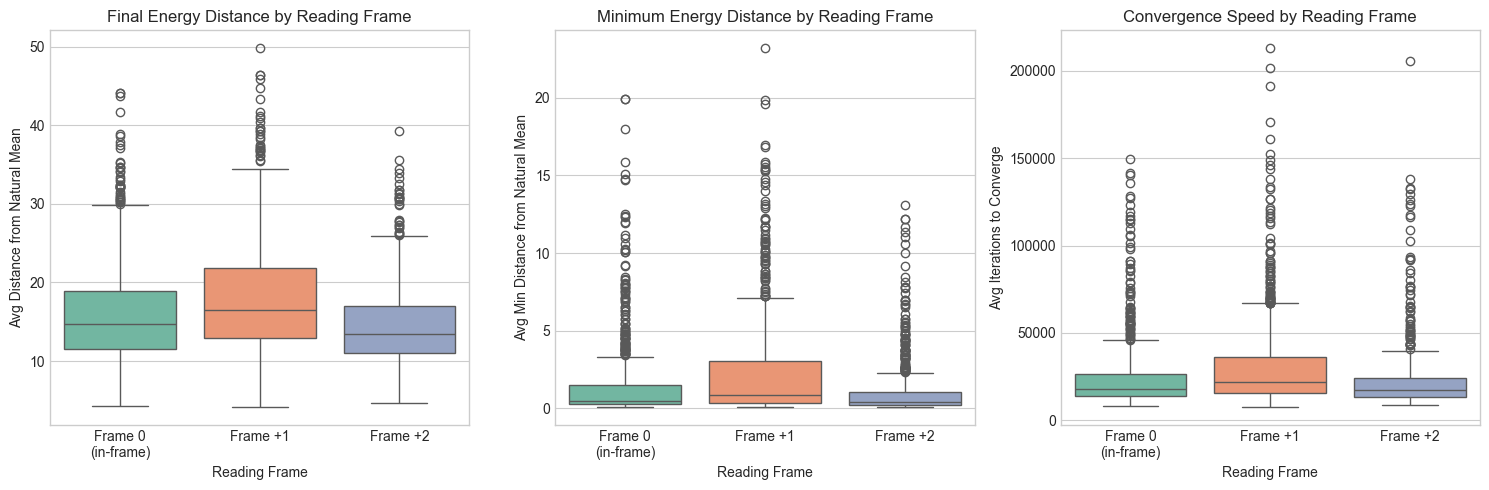

Saved: reading_frame_boxplots.png


In [13]:
# --- BOXPLOT: METRICS BY READING FRAME ---

if 'results_df' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    frame_labels = {0: 'Frame 0\n(in-frame)', 1: 'Frame +1', 2: 'Frame +2'}
    results_df['Frame_Label'] = results_df['Reading_Frame'].map(frame_labels)
    
    # Plot 1: Average Distance
    sns.boxplot(data=results_df, x='Frame_Label', y='Avg_Dist', ax=axes[0], palette='Set2')
    axes[0].set_title('Final Energy Distance by Reading Frame')
    axes[0].set_xlabel('Reading Frame')
    axes[0].set_ylabel('Avg Distance from Natural Mean')
    
    # Plot 2: Minimum Distance
    sns.boxplot(data=results_df, x='Frame_Label', y='Avg_Min_Dist', ax=axes[1], palette='Set2')
    axes[1].set_title('Minimum Energy Distance by Reading Frame')
    axes[1].set_xlabel('Reading Frame')
    axes[1].set_ylabel('Avg Min Distance from Natural Mean')
    
    # Plot 3: Convergence Iterations
    sns.boxplot(data=results_df, x='Frame_Label', y='Avg_Iter_Conv', ax=axes[2], palette='Set2')
    axes[2].set_title('Convergence Speed by Reading Frame')
    axes[2].set_xlabel('Reading Frame')
    axes[2].set_ylabel('Avg Iterations to Converge')
    
    plt.tight_layout()
    plt.savefig('reading_frame_boxplots.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: reading_frame_boxplots.png")

C:\Users\orson\AppData\Local\Temp\ipykernel_15752\2529299583.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=results_df, x='Frame_Label', y='Avg_Dist', ax=axes[0], palette='Set2', inner='quartile')
C:\Users\orson\AppData\Local\Temp\ipykernel_15752\2529299583.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=results_df, x='Frame_Label', y='Avg_Min_Dist', ax=axes[1], palette='Set2', inner='quartile')
C:\Users\orson\AppData\Local\Temp\ipykernel_15752\2529299583.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=

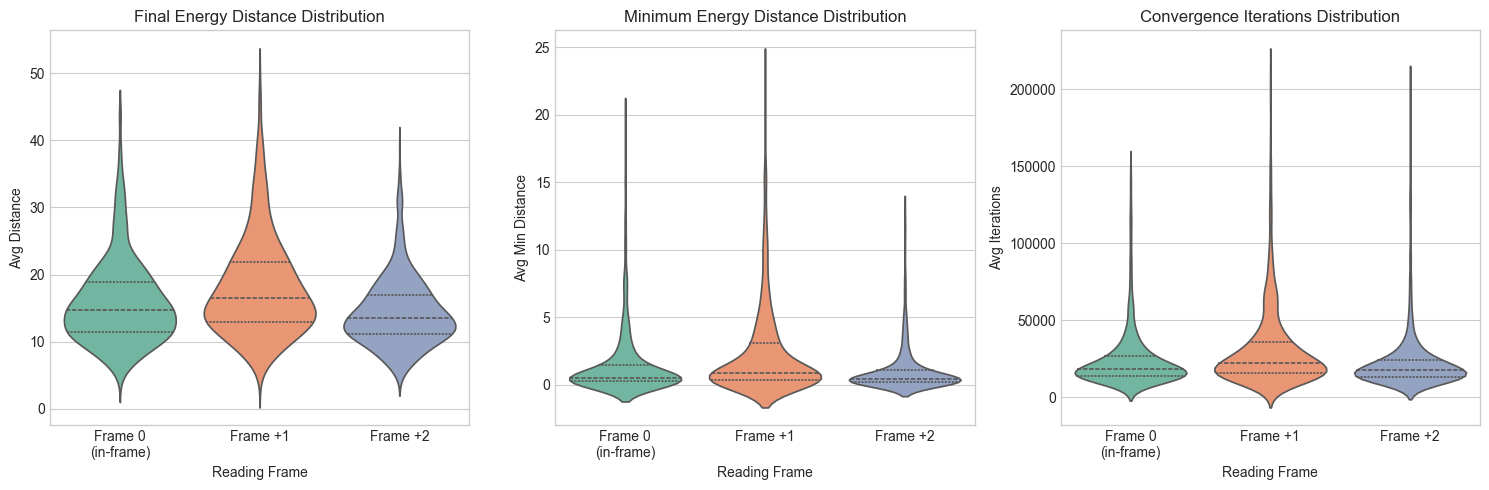

Saved: reading_frame_violins.png


In [14]:
# --- VIOLIN PLOT: DISTRIBUTION COMPARISON ---

if 'results_df' in locals():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    sns.violinplot(data=results_df, x='Frame_Label', y='Avg_Dist', ax=axes[0], palette='Set2', inner='quartile')
    axes[0].set_title('Final Energy Distance Distribution')
    axes[0].set_xlabel('Reading Frame')
    axes[0].set_ylabel('Avg Distance')
    
    sns.violinplot(data=results_df, x='Frame_Label', y='Avg_Min_Dist', ax=axes[1], palette='Set2', inner='quartile')
    axes[1].set_title('Minimum Energy Distance Distribution')
    axes[1].set_xlabel('Reading Frame')
    axes[1].set_ylabel('Avg Min Distance')
    
    sns.violinplot(data=results_df, x='Frame_Label', y='Avg_Iter_Conv', ax=axes[2], palette='Set2', inner='quartile')
    axes[2].set_title('Convergence Iterations Distribution')
    axes[2].set_xlabel('Reading Frame')
    axes[2].set_ylabel('Avg Iterations')
    
    plt.tight_layout()
    plt.savefig('reading_frame_violins.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: reading_frame_violins.png")

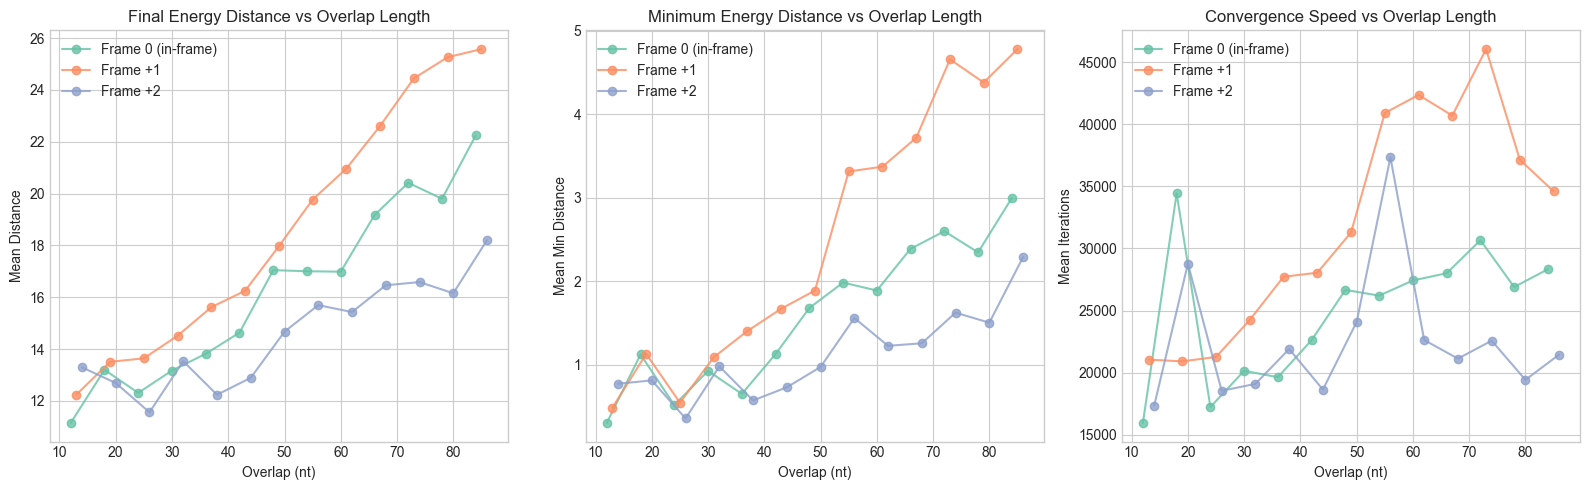

Saved: reading_frame_vs_overlap.png


In [15]:
# --- LINE PLOT: METRICS VS OVERLAP LENGTH BY FRAME ---

if 'results_df' in locals():
    # Aggregate by overlap and frame
    overlap_frame_agg = results_df.groupby(['Overlap', 'Reading_Frame']).agg({
        'Avg_Dist': 'mean',
        'Avg_Min_Dist': 'mean',
        'Avg_Iter_Conv': 'mean'
    }).reset_index()
    
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    frame_colors = {0: '#66c2a5', 1: '#fc8d62', 2: '#8da0cb'}
    frame_names = {0: 'Frame 0 (in-frame)', 1: 'Frame +1', 2: 'Frame +2'}
    
    for frame in [0, 1, 2]:
        frame_data = overlap_frame_agg[overlap_frame_agg['Reading_Frame'] == frame]
        
        axes[0].plot(frame_data['Overlap'], frame_data['Avg_Dist'], 
                     'o-', color=frame_colors[frame], label=frame_names[frame], alpha=0.8)
        axes[1].plot(frame_data['Overlap'], frame_data['Avg_Min_Dist'], 
                     'o-', color=frame_colors[frame], label=frame_names[frame], alpha=0.8)
        axes[2].plot(frame_data['Overlap'], frame_data['Avg_Iter_Conv'], 
                     'o-', color=frame_colors[frame], label=frame_names[frame], alpha=0.8)
    
    axes[0].set_title('Final Energy Distance vs Overlap Length')
    axes[0].set_xlabel('Overlap (nt)')
    axes[0].set_ylabel('Mean Distance')
    axes[0].legend()
    
    axes[1].set_title('Minimum Energy Distance vs Overlap Length')
    axes[1].set_xlabel('Overlap (nt)')
    axes[1].set_ylabel('Mean Min Distance')
    axes[1].legend()
    
    axes[2].set_title('Convergence Speed vs Overlap Length')
    axes[2].set_xlabel('Overlap (nt)')
    axes[2].set_ylabel('Mean Iterations')
    axes[2].legend()
    
    plt.tight_layout()
    plt.savefig('reading_frame_vs_overlap.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: reading_frame_vs_overlap.png")

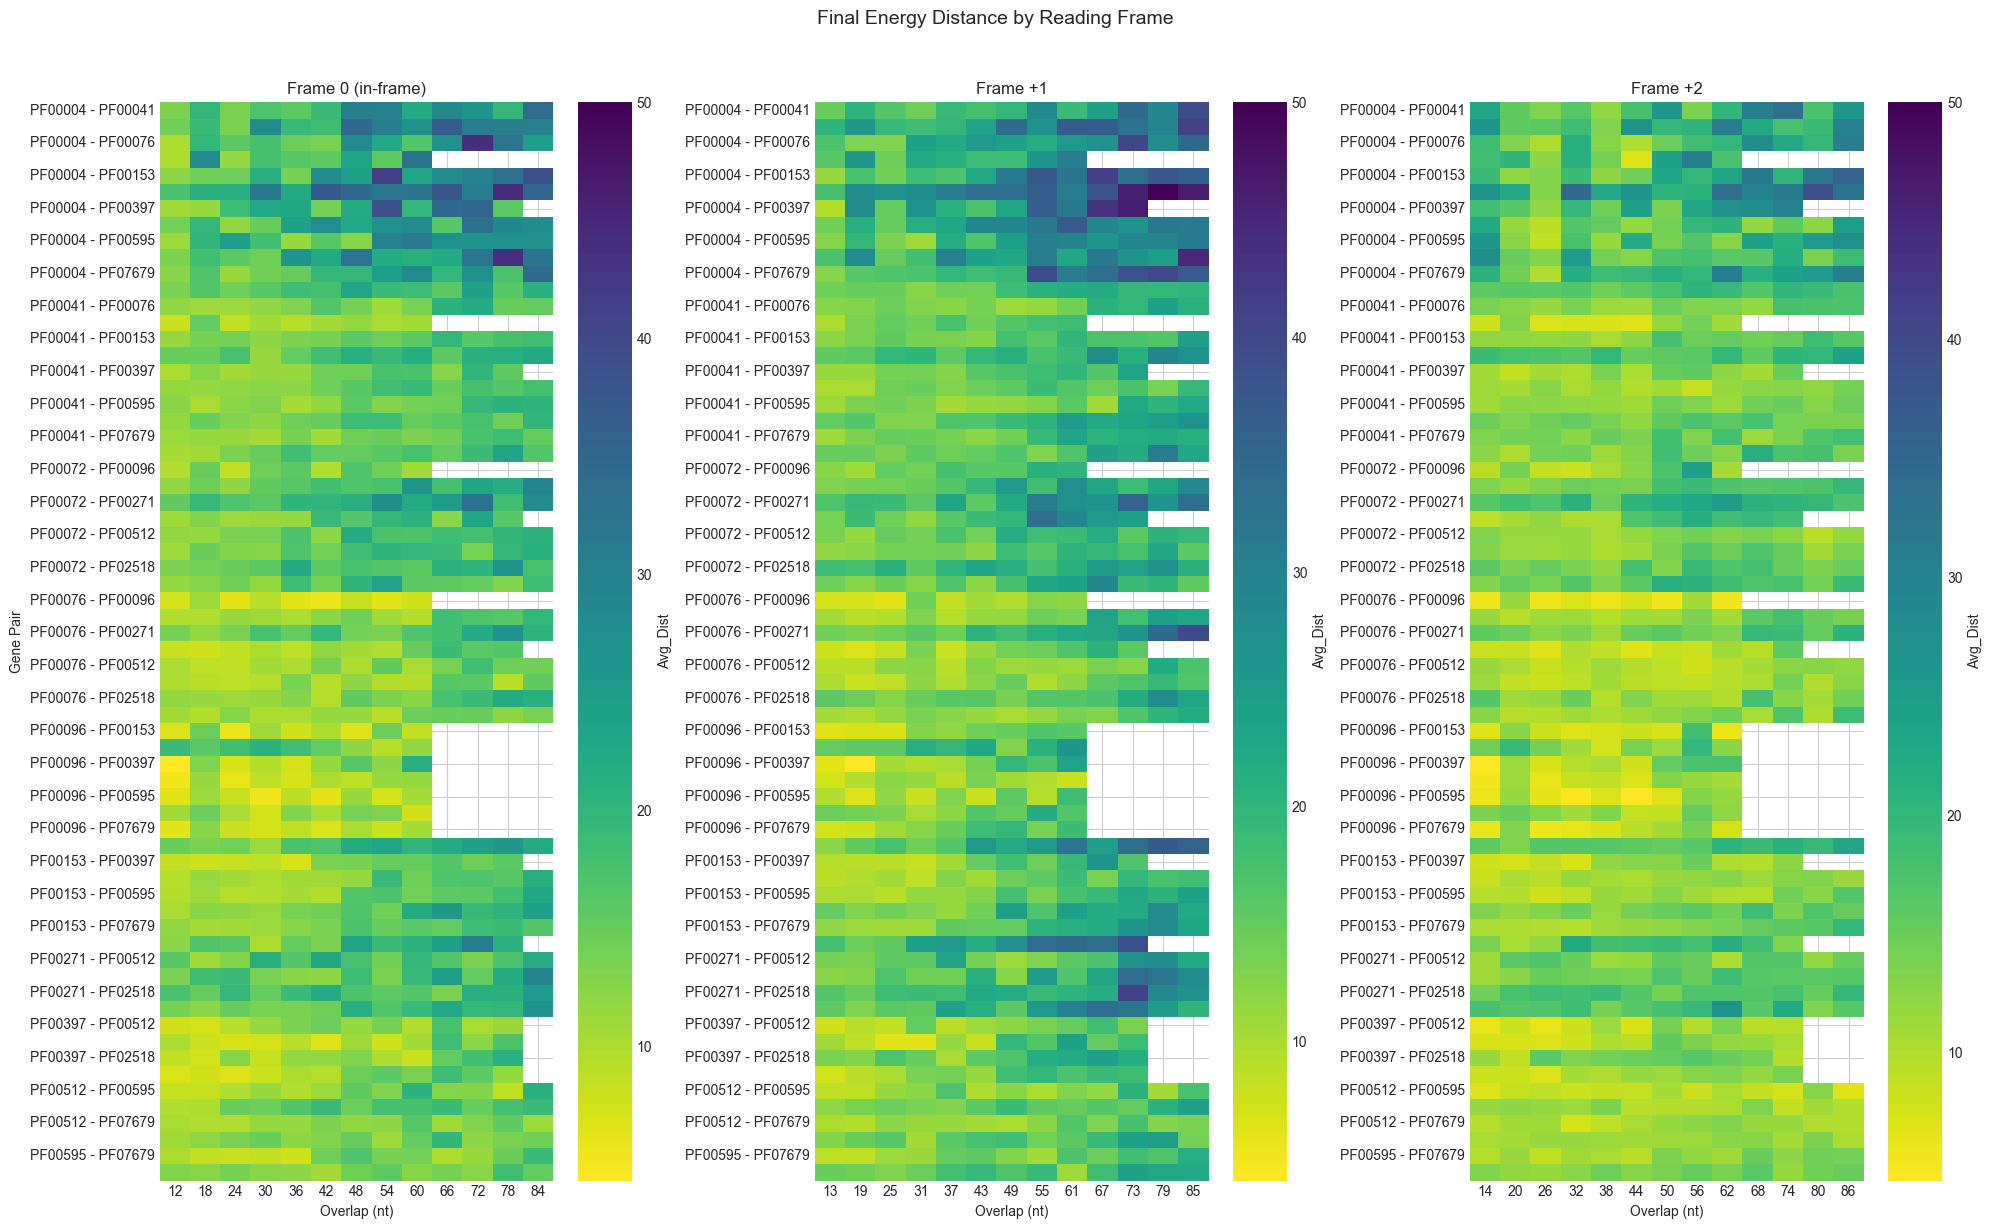

Saved: heatmap_dist_by_frame.png


In [16]:
# --- HEATMAPS: SEPARATE BY READING FRAME ---

def plot_heatmap_by_frame(df, metric, title, vmax=None):
    """Plot heatmaps for each reading frame side by side."""
    fig, axes = plt.subplots(1, 3, figsize=(20, 12))
    
    frame_names = {0: 'Frame 0 (in-frame)', 1: 'Frame +1', 2: 'Frame +2'}
    
    for i, frame in enumerate([0, 1, 2]):
        frame_df = df[df['Reading_Frame'] == frame].copy()
        frame_df['Pair'] = frame_df['PF1'] + ' - ' + frame_df['PF2']
        
        pivot = frame_df.pivot_table(index='Pair', columns='Overlap', values=metric)
        
        sns.heatmap(pivot, cmap='viridis_r', vmax=vmax, ax=axes[i],
                    cbar_kws={'label': metric})
        axes[i].set_title(f'{frame_names[frame]}')
        axes[i].set_xlabel('Overlap (nt)')
        if i == 0:
            axes[i].set_ylabel('Gene Pair')
        else:
            axes[i].set_ylabel('')
    
    plt.suptitle(f'{title}', fontsize=14, y=1.02)
    plt.tight_layout()
    return fig

if 'results_df' in locals():
    fig = plot_heatmap_by_frame(results_df, 'Avg_Dist', 'Final Energy Distance by Reading Frame', vmax=50)
    plt.savefig('heatmap_dist_by_frame.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: heatmap_dist_by_frame.png")

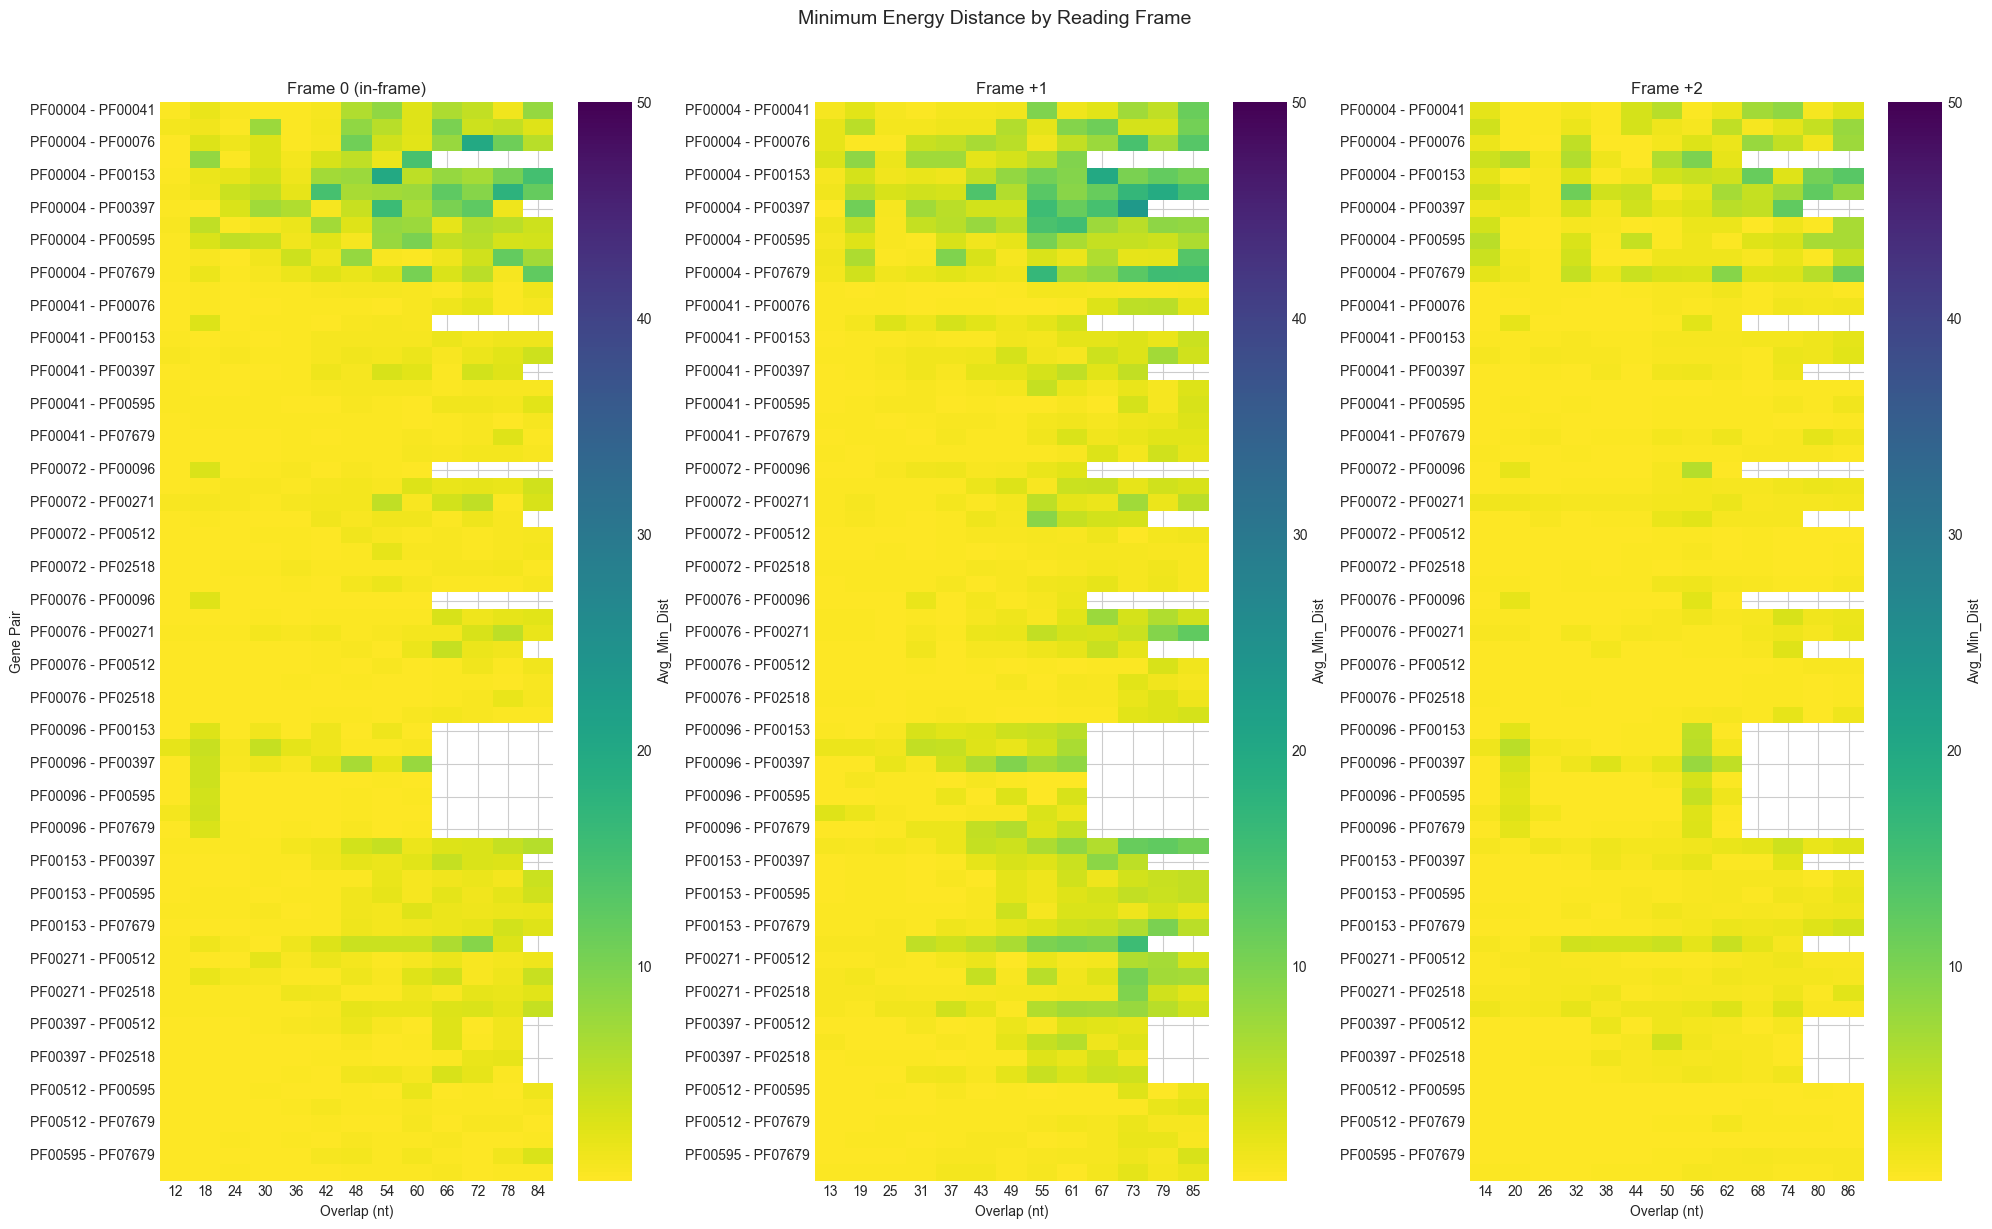

Saved: heatmap_mindist_by_frame.png


In [17]:
# --- HEATMAP: MIN DISTANCE BY FRAME ---

if 'results_df' in locals():
    fig = plot_heatmap_by_frame(results_df, 'Avg_Min_Dist', 'Minimum Energy Distance by Reading Frame', vmax=50)
    plt.savefig('heatmap_mindist_by_frame.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: heatmap_mindist_by_frame.png")

In [18]:
# --- FRAME DIFFERENCE ANALYSIS ---
# For each pair and comparable overlap range, compute frame 0 advantage

if 'results_df' in locals():
    # Group by pair and compute mean metrics per frame
    pair_frame_summary = results_df.groupby(['PF1', 'PF2', 'Reading_Frame']).agg({
        'Avg_Dist': 'mean',
        'Avg_Min_Dist': 'mean'
    }).reset_index()
    
    # Pivot to compare frames
    pivot_dist = pair_frame_summary.pivot_table(
        index=['PF1', 'PF2'], 
        columns='Reading_Frame', 
        values='Avg_Dist'
    )
    
    # Calculate how much better/worse frame 0 is compared to shifted frames
    pivot_dist['Frame0_vs_Frame1'] = pivot_dist[0] - pivot_dist[1]  # Negative = Frame 0 better
    pivot_dist['Frame0_vs_Frame2'] = pivot_dist[0] - pivot_dist[2]
    
    print("=" * 70)
    print("FRAME 0 ADVANTAGE ANALYSIS")
    print("Negative = Frame 0 has LOWER distance (better)")
    print("Positive = Frame 0 has HIGHER distance (worse)")
    print("=" * 70)
    print(f"\nFrame 0 vs Frame +1:")
    print(f"  Mean difference: {pivot_dist['Frame0_vs_Frame1'].mean():.2f}")
    print(f"  Pairs where Frame 0 is better: {(pivot_dist['Frame0_vs_Frame1'] < 0).sum()} / {len(pivot_dist)}")
    
    print(f"\nFrame 0 vs Frame +2:")
    print(f"  Mean difference: {pivot_dist['Frame0_vs_Frame2'].mean():.2f}")
    print(f"  Pairs where Frame 0 is better: {(pivot_dist['Frame0_vs_Frame2'] < 0).sum()} / {len(pivot_dist)}")

FRAME 0 ADVANTAGE ANALYSIS
Negative = Frame 0 has LOWER distance (better)
Positive = Frame 0 has HIGHER distance (worse)

Frame 0 vs Frame +1:
  Mean difference: -2.26
  Pairs where Frame 0 is better: 60 / 66

Frame 0 vs Frame +2:
  Mean difference: 1.49
  Pairs where Frame 0 is better: 13 / 66


In [19]:
# --- SUMMARY CONCLUSION ---

if 'results_df' in locals():
    print("=" * 70)
    print("READING FRAME ANALYSIS SUMMARY")
    print("=" * 70)
    
    # Find best frame for each metric
    frame_means = results_df.groupby('Reading_Frame')[['Avg_Dist', 'Avg_Min_Dist', 'Avg_Iter_Conv']].mean()
    
    best_dist = frame_means['Avg_Dist'].idxmin()
    best_min_dist = frame_means['Avg_Min_Dist'].idxmin()
    best_conv = frame_means['Avg_Iter_Conv'].idxmin()
    
    print(f"\nBest performing frame by metric (lower is better):")
    print(f"  Final Energy Distance:   Frame {best_dist} (mean: {frame_means.loc[best_dist, 'Avg_Dist']:.2f})")
    print(f"  Minimum Energy Distance: Frame {best_min_dist} (mean: {frame_means.loc[best_min_dist, 'Avg_Min_Dist']:.2f})")
    print(f"  Convergence Speed:       Frame {best_conv} (mean: {frame_means.loc[best_conv, 'Avg_Iter_Conv']:.0f} iterations)")
    
    print("\nMean values by frame:")
    print(frame_means.round(2))

READING FRAME ANALYSIS SUMMARY

Best performing frame by metric (lower is better):
  Final Energy Distance:   Frame 2 (mean: 14.38)
  Minimum Energy Distance: Frame 2 (mean: 1.08)
  Convergence Speed:       Frame 2 (mean: 22659 iterations)

Mean values by frame:
               Avg_Dist  Avg_Min_Dist  Avg_Iter_Conv
Reading_Frame                                       
0                 15.92          1.51       24701.69
1                 18.15          2.34       31504.17
2                 14.38          1.08       22658.77
